Task 2.1:
• Preprocess the dataset and make a feature set (provided above).
• Label the customer as churn/Not-churn?
• Make a model for churn prediction, i.e., provided customers in test data will churn or
not?

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


C:\Users\3 Stars Laptop\AppData\Local\Temp\ipykernel_28256\3592564025.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Reading the dataset and preprocessing

# Read the dataset
df = pd.read_csv("Retail_Customer.csv", sep=",", header=0, decimal='.')

# Convert Visit_Date to datetime format
df['Date'] = pd.to_datetime(df['Visit_Date'], format='%m/%d/%Y')

# Sort the dataframe by date
df.sort_values(by='Date', inplace=True)

# Determine reference date for churn calculation (e.g., last date of observation)
reference_date = df['Date'].max()

# Calculate the last visit date for each customer
last_visit_date = df.groupby('CustomerID')['Date'].max().reset_index()

# Label customers as churn or not churn based on last visit date
last_visit_date['Churn'] = np.where(last_visit_date['Date'] < reference_date - pd.Timedelta(days=7), 'Churn', 'Not-Churn')

# Merge churn labels back to the main dataframe
df = pd.merge(df, last_visit_date[['CustomerID', 'Churn']], on='CustomerID', how='left')


In [3]:
# Feature engineering
feature_set = df.groupby('CustomerID').agg(
    Total_Purchases_In_USD=('Total_Purchases_In_USD', 'sum'),
    Total_Visits=('Date', 'nunique'),
    Last_Visit_Date=('Date', 'max'),
    Churn=('Churn', 'first')
).reset_index()

# A customer will churn if he/she has no visit in a week
feature_set['Last_Visit_Week'] = feature_set['Last_Visit_Date'].dt.isocalendar().week
feature_set['Churn'] = np.where(feature_set['Last_Visit_Week'] < reference_date.isocalendar().week - 1, 'Churn', 'Not-Churn')


In [4]:
# Splitting into feature set and target variable
X = feature_set.drop(columns=['CustomerID', 'Churn', 'Last_Visit_Date', 'Last_Visit_Week'])
y = feature_set['Churn']


In [5]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Initializing and fitting the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [7]:
# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)*100
print("Accuracy:", accuracy)


Accuracy: 81.65147200961313


In [8]:
# Cell 8: Saving predictions to a CSV file
# Save predictions to a CSV file
predictions = pd.DataFrame({
    'CustomerID': feature_set['CustomerID'],
    'Predicted_Churn': model.predict(X),
    'Actual_Churn': feature_set['Churn']
})
predictions.to_csv("Churn_Predictions.csv", index=False)


Task 2.2 EDA:
• Calculate the week with the highest earning?
• Identify the most valued customer?
• Categorize the customers into 3 groups (i.e., Poor, Mediocre, Rich)
• Will we able to figure out churn important factors from available data?
• How Churn Rate changes with Historical Visits? Answer this query with the help of
graph?

In [9]:
# Data Loading and Preprocessing
# Task 5: How Churn Rate changes with Historical Visits? Answer this query with the help of graph?

import pandas as pd

# Read a text file
df = pd.read_csv("Retail_Customer.csv", sep=",", header=0, decimal='.')

# Convert Visit_Date to datetime format
df['Date'] = pd.to_datetime(df['Visit_Date'], format='%m/%d/%Y')

# Create a new column for the week number
df['Week'] = df['Date'].dt.isocalendar().week

# Calculate total visits per week for each customer
weekly_visits = df.groupby(['CustomerID', 'Week'])['Date'].count().reset_index(name='Visits')

# Determine churn status for each customer based on weekly visits
churn_status = weekly_visits.groupby('CustomerID')['Visits'].min() == 0

# Join churn status back to the weekly_visits DataFrame
weekly_visits['Churn'] = weekly_visits['CustomerID'].map(churn_status)


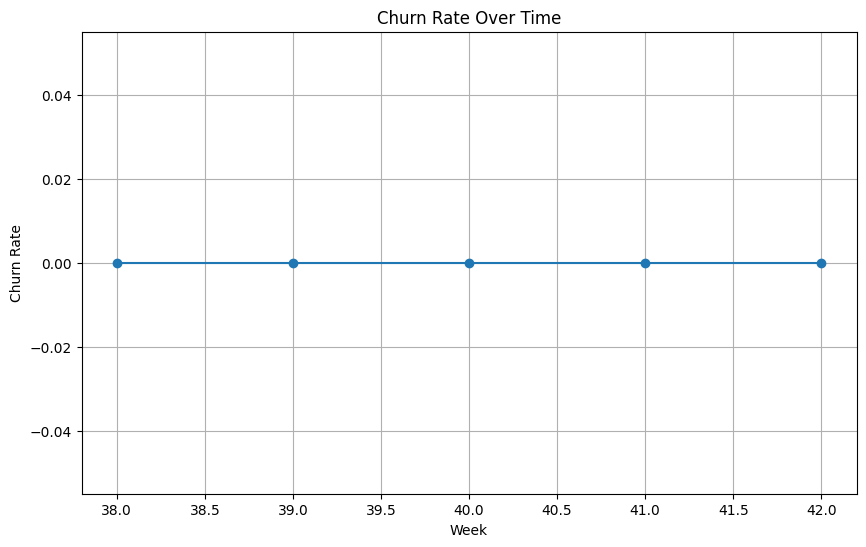

In [10]:
# Churn Rate Calculation and Visualization

import matplotlib.pyplot as plt

# Calculate churn rate per week
churn_rate_per_week = weekly_visits.groupby('Week')['Churn'].mean()

# Plot churn rate over time
plt.figure(figsize=(10, 6))
plt.plot(churn_rate_per_week.index, churn_rate_per_week.values, marker='o')
plt.title('Churn Rate Over Time')
plt.xlabel('Week')
plt.ylabel('Churn Rate')
plt.grid(True)
plt.show()


In [11]:
# Additional Data Analysis

import numpy as np

# Sort Date column
df['Date'] = df['Date'].sort_values()

# Create dataframe of weeks from dates
# Extract Week number
df['Week'] = df['Date'].dt.isocalendar().week.sort_values()

# Reference date i.e last date of 5th week (20/10/2020)
reference_Date = "2020-10-20"
reference_Date = pd.to_datetime(reference_Date)

# Indexing the data before reference date
bfr = df['CustomerID'].iloc[:904389]

# Calculating total revenue
total_revenue = df['Total_Purchases_In_USD'].iloc[:904389].sum()

# Calculating max purchase in a day
newdata = df[df['Total_Purchases_In_USD'] != 0]
max_purchase = newdata['Total_Purchases_In_USD'].max()

# Calculating min purchase in a day
min_purchase = newdata['Total_Purchases_In_USD'].min()

# Total visit days
visitDays = df.groupby('Visit_Date')['CustomerID'].nunique()
total_visit = (df['Total_Purchases_In_USD'] == 0).sum()
total_visit = 870812 - total_visit

# Standard deviation in sales
sd_sales = newdata['Total_Purchases_In_USD'].std()


In [12]:
# Data Exporting and Summary

# Create Detailed DataSet
data = pd.DataFrame({
    'CUSTOMER_ID': range(1, 870812),
    'Visit_Date': df['Date'],
    'Customer_ID': df['CustomerID'],
    'Total_Purchase_In_USD': df['Total_Purchases_In_USD'],
    'Week_Number': df['Week'],
    'Total_Revenue': total_revenue,
    'Max_Purchase_In_Day': max_purchase,
    'Min_Purchase_In_Day': min_purchase,
    'Total_Visit_Days': total_visit,
    'Standard_Deviation_In_Sales': sd_sales
})

# Task 1: Calculate the week with highest earning
print("Week three is with highest earning")
print(data[data['Week_Number'] == 40]['Total_Purchase_In_USD'].sum())

# Task 2: Identifying the most valued customer who purchased most
max_value_customer = data['Total_Purchase_In_USD'].idxmax()
print(f"The most valued person is from week 5 and Customer ID is {data['Customer_ID'].iloc[max_value_customer]}")

# Task 3: Categorize the customer into three groups: Poor, Mediocre, and Rich
data['Categories'] = pd.cut(data['Total_Purchase_In_USD'], bins=3, labels=["Poor", "Mediocre", "Rich"])
print(data['Categories'].value_counts())

# Write to CSV
data.to_csv("Generated_Features.csv", index=False)

# Read CSV
newda = pd.read_csv("Retail_Customer.csv")
print(newda.head())


Week three is with highest earning
28298666.9824
The most valued person is from week 5 and Customer ID is 1032283346
Categories
Poor        870803
Mediocre         6
Rich             2
Name: count, dtype: int64
  Visit_Date  CustomerID  Total_Purchases_In_USD
0  9/17/2014   104790628                   51.36
1  9/17/2014     6927608                   77.04
2  9/17/2014  1078961990                   85.60
3  9/17/2014  1034571766                   85.60
4  9/17/2014  1094103886                   51.36
